In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

In [81]:
idx = pd.IndexSlice
original_data = pd.read_table('results_renamed.tsv')

/tmp/ipykernel_7266/2326957964.py:2: DtypeWarning: Columns (0,1,3,5,6,7,9,12,13,14,15,16,17,18,20,22,24,25,28,29,30,34,35,44,53) have mixed types. Specify dtype option on import or set low_memory=False.
  original_data = pd.read_table('results_renamed.tsv')


In [4]:
data = original_data.copy()

In [5]:
label_freq_columns = (
    data.loc[:, data.columns.str.endswith("label_frequency_estimates_")]
    .map(lambda x: np.fromstring(x[1:-1], sep=",") if isinstance(x, str) else x)
)

data["label_freq"] = label_freq_columns.apply(
    lambda s: np.nan if s.isna().all() else s.loc[s.first_valid_index()],
    axis=1,
)
display(data["label_freq"].iloc[40:60])


40    [0.9892717308953974, 0.955411236465236, 0.9841...
41    [0.9935575456635936, 0.9568323556457584, 0.982...
42    [0.9909454036449018, 0.9439453621838395, 0.984...
43    [0.9901758222793468, 0.9313461070283305, 0.992...
44                                                  NaN
45    [0.3748365410863873, 0.3144704628041314, 0.314...
46    [0.9782943396998618, 0.9795693879836882, 0.980...
47    [0.9816852815396397, 0.9750189375488455, 0.977...
48    [0.9863942719844271, 0.9879272819905515, 0.982...
49    [0.9941032916472188, 0.9755160495152632, 0.979...
50    [0.9865767879975544, 0.9877804714587454, 0.973...
51    [0.9771704369206863, 0.9904237483346402, 0.968...
52    [0.9890267875511116, 0.9889733365553771, 0.970...
53    [0.9833048749193614, 0.9929726285155556, 0.975...
54    [0.9904369306762979, 0.9829856819960708, 0.972...
55                                                  NaN
56    [0.2918227760082664, 0.35998650858944975, 0.36...
57    [0.2918227760082664, 0.35998650858944975, 

In [6]:
data["avg_label_freq"] = data["label_freq"].copy()
data.loc[~data.avg_label_freq.isna(), "avg_label_freq"] = (
    data.loc[~data.avg_label_freq.isna(), "avg_label_freq"].map(lambda x: x.mean())
)
data["avg_label_freq"].iloc[40:60]

40     0.95947
41     0.96316
42    0.961122
43    0.963665
44         NaN
45      0.3092
46     0.94038
47    0.945209
48     0.95989
49    0.959468
50    0.956096
51     0.95649
52    0.963391
53    0.962404
54      0.9644
55         NaN
56    0.281794
57    0.281794
58    0.281794
59    0.281794
Name: avg_label_freq, dtype: object

In [7]:
data = data.loc[data.level.astype(str).str.match(r"^\d+$")]
data.loc[:, "level"] = data.loc[:, "level"].astype(int)

In [8]:
data["estimator.name"] = data["original_estimator_name"] + "__" + data["wrapper.name"].astype(str)
data = (
    data.set_index([
        "cv.fold", "original_estimator_name", "dataset.name",
        "avg_label_freq", "level",
    ])
    .rename_axis(["fold", "estimator", "dataset", "avg_label_freq", "level"])
)
score_columns_mask = data.columns.str.match(r"results\.(test|train).*")
data = data.loc[:, score_columns_mask]

In [9]:
metric = (
    data.columns#[score_columns_mask]
    .str.removeprefix("results.")
    .str.removeprefix("train_")
    .str.removeprefix("test_")
    .str.removesuffix("_internal")
    .str.removesuffix("_oob")
    .str.removesuffix("_masked")
    .rename("metric")
    # .to_series()
    # .set_axis(expected_best.index)
)

data.columns = pd.MultiIndex.from_tuples(
    ((m, s.replace("_" + m, "").removeprefix("results."))
    for m, s in zip(metric, data.columns)),
    names=("metric", "scorer"),
)

In [10]:
data = data.sort_index(axis=1)

In [11]:
filtered_data = data.loc[:, pd.IndexSlice[["neg_hamming_loss_micro", "average_precision_micro", "roc_auc_micro"], :]]
filtered_data = filtered_data.filter(like="cascade_proba", axis=0)

In [12]:
filtered_data.reset_index().estimator.value_counts()

estimator
cascade_proba__90    935
cascade_proba__70    935
cascade_proba        935
cascade_proba__50    935
Name: count, dtype: int64

scorer
train_internal        0.794545
train_oob_internal    0.810909
dtype: float64


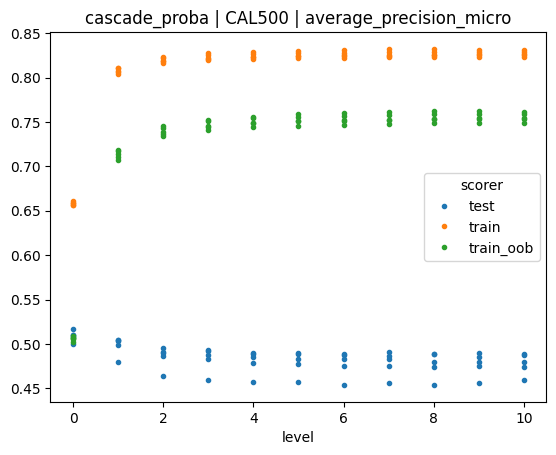

In [13]:
for gname, g in filtered_data.groupby(level=["estimator", "dataset"]):
    for gname2, g2 in g.T.groupby(level="metric"):
        g2 = g2.T.droplevel("metric", axis=1).reset_index().sort_values("level")
        # g2[g2["cv.fold"] == 2].plot(  # NOTE: Each fold results are drastically different
        g2.plot(
            x="level",
            y=["test", "train", "train_oob"],
            title=f"{' | '.join(gname)} | {gname2}",
            style=".",
        )

        print(
            g2.groupby("fold").apply(
                lambda x: x[["train_internal", "train_oob_internal"]].corrwith(
                    g2.test, method="spearman", numeric_only=True
                )
            ).abs().mean()
        )
        break
    break

In [14]:
allsets = (
    filtered_data.stack(["metric", "scorer"])
    .groupby(level=["estimator", "dataset", "fold", "metric", "scorer"])
    .rank(pct=True)  # Rank by cascade level
    .groupby(level=["estimator", "dataset", "metric", "scorer", "level"])
    .mean()  # Average over folds
)
allsets

estimator          dataset  metric                   scorer              level
cascade_proba      CAL500   average_precision_micro  test                0        1.000000
                                                                         1        0.909091
                                                                         2        0.781818
                                                                         3        0.745455
                                                                         4        0.527273
                                                                                    ...   
cascade_proba__90  yeast    roc_auc_micro            train_oob_internal  6        0.581818
                                                                         7        0.472727
                                                                         8        0.400000
                                                                         9        0.600000
           

,estimator,dataset,metric,scorer,level,0
0,cascade_proba,CAL500,average_precision_micro,test,0,1.000000
1,cascade_proba,CAL500,average_precision_micro,test,1,0.909091
2,cascade_proba,CAL500,average_precision_micro,test,2,0.781818
3,cascade_proba,CAL500,average_precision_micro,test,3,0.745455
4,cascade_proba,CAL500,average_precision_micro,test,4,0.527273
...,...,...,...,...,...,...
1117,cascade_proba,yeast,average_precision_micro,train_oob_internal,6,0.672727
1118,cascade_proba,yeast,average_precision_micro,train_oob_internal,7,0.872727
1119,cascade_proba,yeast,average_precision_micro,train_oob_internal,8,0.854545
1120,cascade_proba,yeast,average_precision_micro,train_oob_internal,9,0.927273


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 29.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 23.5% of the points cannot be placed; you may want to d

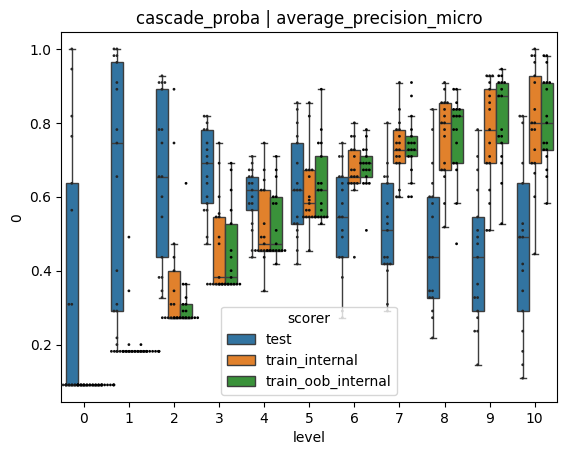

,estimator,dataset,metric,scorer,level,0
0,cascade_proba,CAL500,neg_hamming_loss_micro,test,0,0.963636
1,cascade_proba,CAL500,neg_hamming_loss_micro,test,1,0.945455
2,cascade_proba,CAL500,neg_hamming_loss_micro,test,2,0.818182
3,cascade_proba,CAL500,neg_hamming_loss_micro,test,3,0.672727
4,cascade_proba,CAL500,neg_hamming_loss_micro,test,4,0.400000
...,...,...,...,...,...,...
1117,cascade_proba,yeast,neg_hamming_loss_micro,train_oob_internal,6,0.636364
1118,cascade_proba,yeast,neg_hamming_loss_micro,train_oob_internal,7,0.790909
1119,cascade_proba,yeast,neg_hamming_loss_micro,train_oob_internal,8,0.863636
1120,cascade_proba,yeast,neg_hamming_loss_micro,train_oob_internal,9,0.827273


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


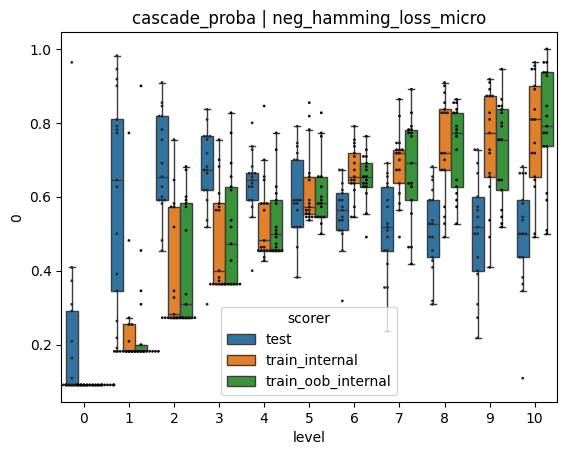

,estimator,dataset,metric,scorer,level,0
0,cascade_proba,CAL500,roc_auc_micro,test,0,1.000000
1,cascade_proba,CAL500,roc_auc_micro,test,1,0.909091
2,cascade_proba,CAL500,roc_auc_micro,test,2,0.818182
3,cascade_proba,CAL500,roc_auc_micro,test,3,0.727273
4,cascade_proba,CAL500,roc_auc_micro,test,4,0.581818
...,...,...,...,...,...,...
1117,cascade_proba,yeast,roc_auc_micro,train_oob_internal,6,0.709091
1118,cascade_proba,yeast,roc_auc_micro,train_oob_internal,7,0.909091
1119,cascade_proba,yeast,roc_auc_micro,train_oob_internal,8,0.800000
1120,cascade_proba,yeast,roc_auc_micro,train_oob_internal,9,0.872727


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 5.9% of the points cannot be placed; you may want to de

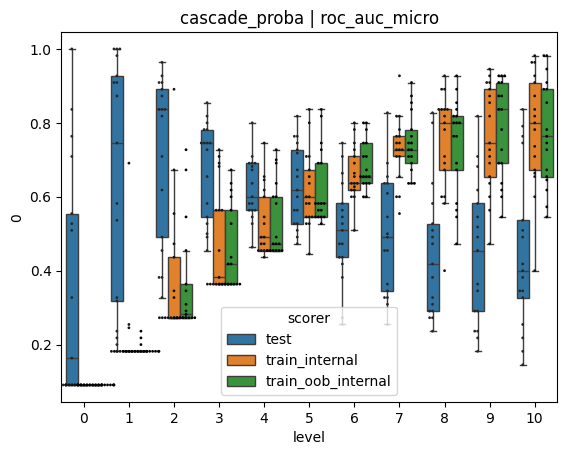

,estimator,dataset,metric,scorer,level,0
0,cascade_proba__50,CAL500,average_precision_micro,test,0,1.000000
1,cascade_proba__50,CAL500,average_precision_micro,test,1,0.909091
2,cascade_proba__50,CAL500,average_precision_micro,test,2,0.818182
3,cascade_proba__50,CAL500,average_precision_micro,test,3,0.727273
4,cascade_proba__50,CAL500,average_precision_micro,test,4,0.636364
...,...,...,...,...,...,...
1304,cascade_proba__50,yeast,average_precision_micro,train_oob_internal,6,0.654545
1305,cascade_proba__50,yeast,average_precision_micro,train_oob_internal,7,0.800000
1306,cascade_proba__50,yeast,average_precision_micro,train_oob_internal,8,0.836364
1307,cascade_proba__50,yeast,average_precision_micro,train_oob_internal,9,0.836364


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 23.5% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


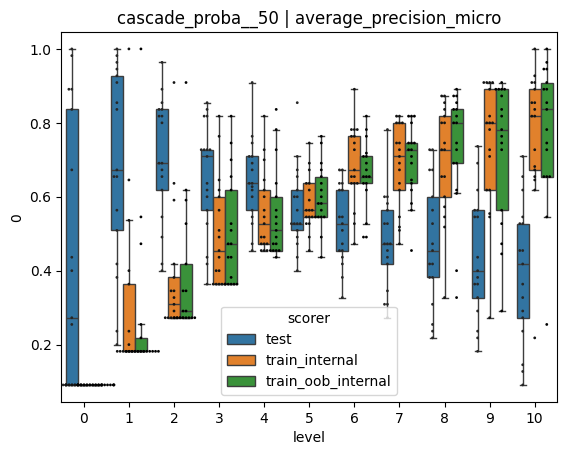

,estimator,dataset,metric,scorer,level,0
0,cascade_proba__50,CAL500,neg_hamming_loss_micro,test,0,0.090909
1,cascade_proba__50,CAL500,neg_hamming_loss_micro,test,1,0.236364
2,cascade_proba__50,CAL500,neg_hamming_loss_micro,test,2,0.427273
3,cascade_proba__50,CAL500,neg_hamming_loss_micro,test,3,0.454545
4,cascade_proba__50,CAL500,neg_hamming_loss_micro,test,4,0.609091
...,...,...,...,...,...,...
1304,cascade_proba__50,yeast,neg_hamming_loss_micro,train_oob_internal,6,0.618182
1305,cascade_proba__50,yeast,neg_hamming_loss_micro,train_oob_internal,7,0.790909
1306,cascade_proba__50,yeast,neg_hamming_loss_micro,train_oob_internal,8,0.818182
1307,cascade_proba__50,yeast,neg_hamming_loss_micro,train_oob_internal,9,0.890909


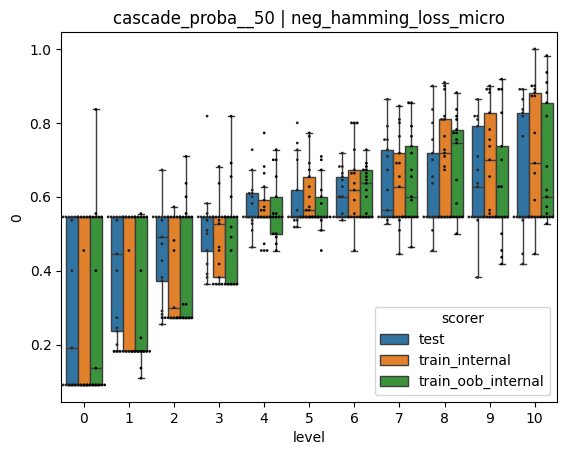

,estimator,dataset,metric,scorer,level,0
0,cascade_proba__50,CAL500,roc_auc_micro,test,0,0.963636
1,cascade_proba__50,CAL500,roc_auc_micro,test,1,0.945455
2,cascade_proba__50,CAL500,roc_auc_micro,test,2,0.818182
3,cascade_proba__50,CAL500,roc_auc_micro,test,3,0.727273
4,cascade_proba__50,CAL500,roc_auc_micro,test,4,0.581818
...,...,...,...,...,...,...
1304,cascade_proba__50,yeast,roc_auc_micro,train_oob_internal,6,0.709091
1305,cascade_proba__50,yeast,roc_auc_micro,train_oob_internal,7,0.690909
1306,cascade_proba__50,yeast,roc_auc_micro,train_oob_internal,8,0.672727
1307,cascade_proba__50,yeast,roc_auc_micro,train_oob_internal,9,0.727273


/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 35.3% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 17.6% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)
/home/pedro/mestrado/biomal_repo/scripts/cascade_forests/env/lib/python3.11/site-packages/seaborn/categorical.py:3370: UserWarning: 23.5% of the points cannot be placed; you may want to de

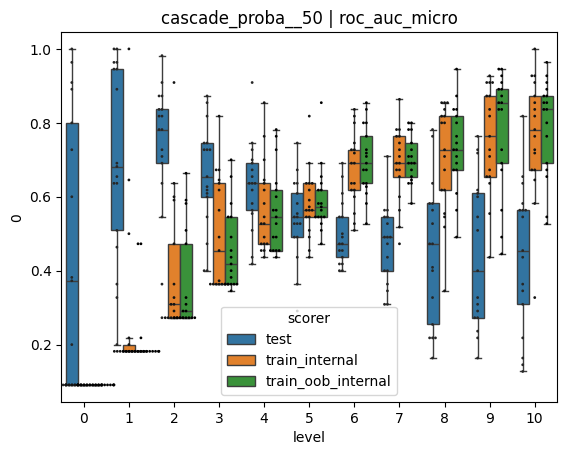

In [15]:
count = 0
for gname, g in allsets.groupby(level=["estimator", "metric"]):#, "scorer"]):
# for gname, g in allsets.groupby(level=["estimator.name", "metric", "scorer"]):
    g = g.reset_index()
    g = g[g["scorer"].isin(("test", "train_internal", "train_oob_internal"))]
    display(g)
    sns.boxplot(g, x="level", y=0, hue="scorer", showfliers=False)
    sns.swarmplot(g, x="level", y=0, hue="scorer", palette="dark:k", dodge=True, size=2, legend=False)
    # sns.boxplot(g, x="level", y=0, hue="scorer")
    plt.title(f"{' | '.join(gname)}")
    plt.show()
    count += 1
    if count == 6: break

In [99]:
imputation_scores = data.loc[
    data.index.get_level_values("level") > 0,
    pd.IndexSlice[
        ["tp_micro", "tn_micro", "fp_micro", "fn_micro", "recall_micro", "precision_micro"],
        ["train", "train_internal", "train_masked"],
    ]
]
imputation_scores = imputation_scores.filter(like="cascade_scar_proba", axis=0)
imputation_scores = imputation_scores.dropna(how="any")
imputation_scores

metric                                                               tp_micro  \
scorer                                                                  train   
fold estimator              dataset            avg_label_freq level             
0    cascade_scar_proba__50 VirusPseAAC        0.737022       1      0.017964   
                                               0.768366       2      0.027944   
                                               0.769011       3      0.031936   
                                               0.769425       4      0.031936   
                                               0.771844       5      0.029940   
...                                                                       ...   
4    cascade_scar_proba__70 GrampositivePseAAC 0.956089       6      0.039357   
                                               0.953808       7      0.039357   
                                               0.960498       8      0.040964   
                                               0.953207       9      0.037751   
                                               0.962933       10     0.038554   

metric                                                                              \
scorer                                                              train_internal   
fold estimator              dataset            avg_label_freq level                  
0    cascade_scar_proba__50 VirusPseAAC        0.737022       1           0.017964   
                                               0.768366       2           0.027944   
                                               0.769011       3           0.031936   
                                               0.769425       4           0.031936   
                                               0.771844       5           0.029940   
...                                                                            ...   
4    cascade_scar_proba__70 GrampositivePseAAC 0.956089       6           0.039357   
                                               0.953808       7           0.039357   
                                               0.960498       8           0.040964   
                                               0.953207       9           0.037751   
                                               0.962933       10          0.038554   

metric                                                                            \
scorer                                                              train_masked   
fold estimator              dataset            avg_label_freq level                
0    cascade_scar_proba__50 VirusPseAAC        0.737022       1              0.0   
                                               0.768366       2              0.0   
                                               0.769011       3              0.0   
                                               0.769425       4              0.0   
                                               0.771844       5              0.0   
...                                                                          ...   
4    cascade_scar_proba__70 GrampositivePseAAC 0.956089       6              0.0   
                                               0.953808       7              0.0   
                                               0.960498       8              0.0   
                                               0.953207       9              0.0   
                                               0.962933       10             0.0   

metric                                                               tn_micro  \
scorer                                                                  train   
fold estimator              dataset            avg_label_freq level             
0    cascade_scar_proba__50 VirusPseAAC        0.737022       1      0.676647   
                                               0.768366       2      0.676647   
                                               0.769011       3      0.676647 

In [117]:
imputation_scores["expected_p"] = (
    imputation_scores.loc[:, idx[["tp_micro", "fn_micro"], "train_internal"]].abs().sum(axis=1)
    / imputation_scores.reset_index("avg_label_freq")["avg_label_freq"]
)

p = imputation_scores.loc[:, idx[["tp_micro", "fn_micro"], "train"]].abs().sum(axis=1)

allsets_imputation = (
    imputation_scores.abs()
    .div(p, axis=0)  # Normalize by number of labels
    .groupby(level=["estimator", "dataset", "level"])
    .mean()  # Average over folds
    .groupby(level=["estimator", "level"])
    .mean()  # Average over datasets
)

In [118]:
allsets_imputation

metric                        tp_micro                              tn_micro  \
scorer                           train train_internal train_masked     train   
estimator              level                                                   
cascade_scar_proba__50 1      0.425168       0.291015     0.153847  4.393288   
                       2      0.471152       0.320348     0.173263  4.378925   
                       3      0.489198       0.329001     0.184201  4.372325   
                       4      0.495070       0.331179     0.188484  4.368596   
                       5      0.503929       0.335483     0.193739  4.365140   
                       6      0.508452       0.337583     0.196506  4.362452   
                       7      0.510596       0.338148     0.198324  4.359423   
                       8      0.510981       0.338159     0.198755  4.357529   
                       9      0.512178       0.338550     0.199615  4.356716   
                       10     0.514898       0.339934     0.201185  4.355039   
cascade_scar_proba__70 1      0.200701       0.116656     0.090127  4.419349   
                       2      0.265051       0.145806     0.128332  4.393384   
                       3      0.286987       0.153592     0.143701  4.388818   
                       4      0.297572       0.157027     0.151374  4.385430   
                       5      0.305714       0.159695     0.157291  4.382734   
                       6      0.311387       0.161215     0.161810  4.380984   
                       7      0.315605       0.162405     0.165061  4.379590   
                       8      0.318235       0.163463     0.166793  4.378452   
                       9      0.321483       0.164687     0.168994  4.377779   
                       10     0.324555       0.165802     0.171082  4.376590   
cascade_scar_proba__90 1      0.071117       0.021820     0.050238  4.444815   
                       2      0.097925       0.032403     0.066938  4.411362   
                       3      0.107281       0.035303     0.073585  4.403360   
                       4      0.110776       0.035792     0.076677  4.399547   
                       5      0.115090       0.036618     0.080263  4.396826   
                       6      0.117719       0.037219     0.082339  4.394195   
                       7      0.119963       0.037610     0.084237  4.393015   
                       8      0.121014       0.037775     0.085140  4.391610   
                       9      0.122435       0.038081     0.086276  4.390729   
                       10     0.123052       0.037990     0.087005  4.390374   

metric                                                    fp_micro  \
scorer                       train_internal train_masked     train   
estimator              level                                         
cascade_scar_proba__50 1           4.756458     4.800994  0.146700   
                       2           4.725445     4.784334  0.161062   
                       3           4.709451     4.776863  0.167662   
                       4           4.702029     4.772644  0.171391   
                       5           4.694017     4.768674  0.174848   
                       6           4.688906     4.765684  0.177536   
                       7           4.684299     4.762312  0.180564   
                       8           4.682031     4.760248  0.182458   
                       9           4.680412     4.759418  0.183272   
                       10          4.677398     4.757576  0.184949   
cascade_scar_proba__70 1           5.030704     4.656346  0.120592   
                       2           4.969539     4.628327  0.146556   
                       3           4.950823     4.623390  0.151123   
                       4           4.940285     4.619798  0.154511   
                       5           4.932115     4.616966  0.157207   
                       6           4.926211     4.615119  0.158957   
                       7     

cascade_scar_proba__50


KeyError: 'expected_p'

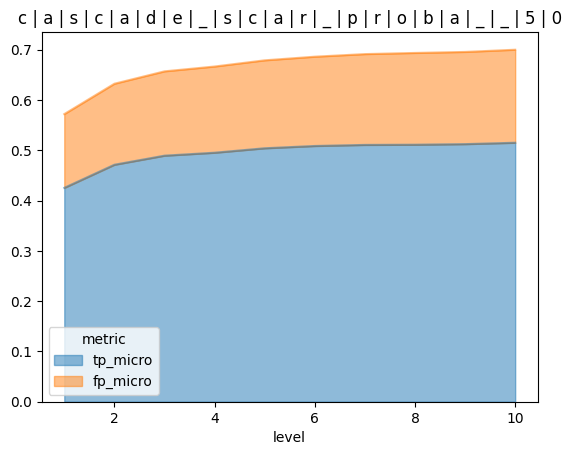

In [119]:
count = 0
for gname, g in allsets_imputation.groupby(level="estimator"):
    print(gname)

    g = g.loc[:, idx[:, "train"]].droplevel("scorer", axis=1).reset_index("level")

    ax = g.plot.area(
        x="level",
        y=["tp_micro", "fp_micro"],
        title=f"{' | '.join(map(str, gname))}",
        stacked=True,
        alpha=0.5,
    )
    g.plot(
        ax=ax,
        x="level",
        y="expected_p",
        color="k",
        linestyle="--",
    )
    ax.set_ylim(0, 1)

    plt.show()
    count += 1
    if count == 3: break

('cascade_scar_proba__50', 'CAL500')


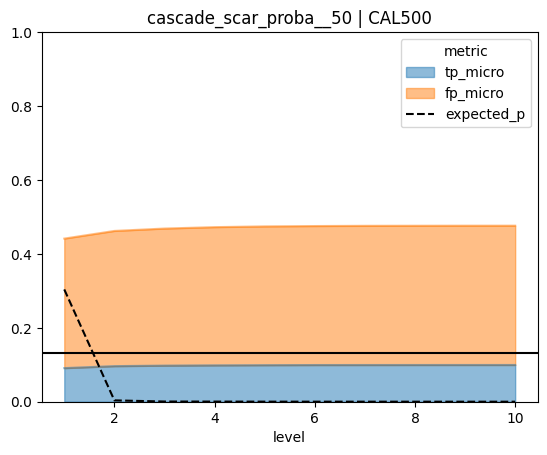

('cascade_scar_proba__50', 'CHD_49')


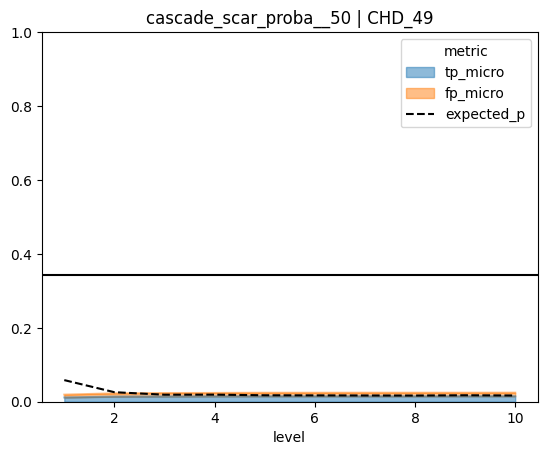

('cascade_scar_proba__50', 'Gram_negative')


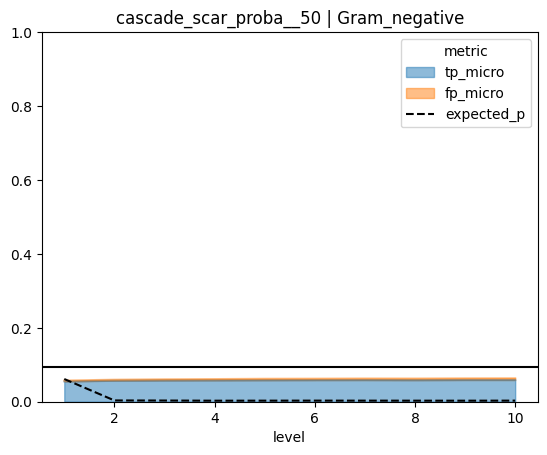

('cascade_scar_proba__50', 'Gram_positive')


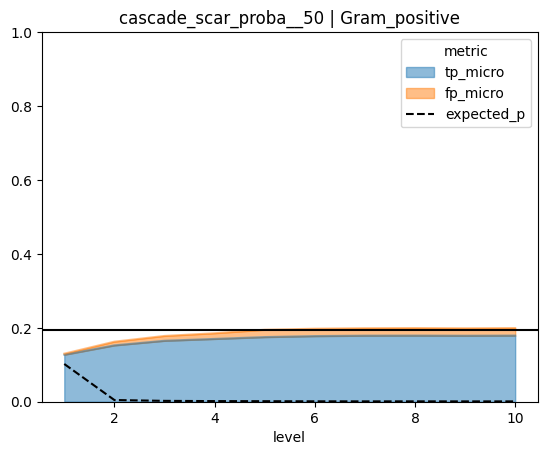

('cascade_scar_proba__50', 'GrampositivePseAAC')


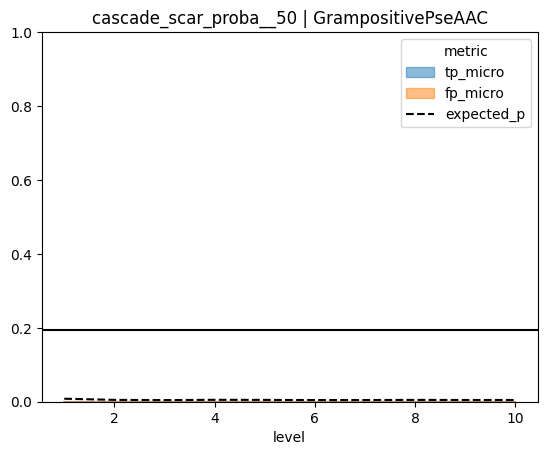

In [106]:
count = 0
for gname, g in imputation_scores.groupby(level=["estimator", "dataset"]):
    print(gname)

    expected_p = (
        g.loc[:, idx[["tp_micro", "fn_micro"], "train_internal"]].abs().sum(axis=1)
        * (1 / g.reset_index("avg_label_freq")["avg_label_freq"] - 1)
    )
    expected_p /= (
        expected_p
        + g.loc[:, idx[["tn_micro", "fp_micro"], "train_internal"]].abs().sum(axis=1)
    )

    expected_p = (
        expected_p.groupby(level="level")
        .mean()
        .rename("expected_p")
        .reset_index("level")
    )

    g = g.loc[:, idx[:, "train_masked"]].droplevel("scorer", axis=1)
    g = g.groupby(level=["level"]).mean().reset_index()
    g = g.abs()  # fn and fp are negative to enforce greater-is-better
    # display(g)

    tp, tn, fp, fn = g.iloc[0][["tp_micro", "tn_micro", "fp_micro", "fn_micro"]]
    p, n = tp + fn, tn + fp

    ax = g.plot.area(
        x="level",
        # y=["tp_micro", "fn_micro", "fp_micro"],  #, "tn_micro"],
        y=["tp_micro", "fp_micro"],  #, "tn_micro"],
        title=f"{' | '.join(map(str, gname))}",
        stacked=True,
        alpha=0.5,
    )
    expected_p.plot(
        ax=ax,
        x="level",
        y="expected_p",
        color="k",
        linestyle="--",
    )
    ax.axhline(p, color="k", linestyle="-")
    ax.set_ylim(0, 1)

    plt.show()
    count += 1
    if count == 5: break